# Load and test data

In [1]:
from imports2 import *
from neural_network_1_architecture_sprint_code_2019_07_28 import *
from data_testing_suite import *
X_train, Y_train, X_valid, Y_valid = data_loading('2019_07_30')
print(Y_valid.shape, X_valid.shape, X_train.shape, Y_train.shape)
test_data(X_train, Y_train, X_valid, Y_valid)

Using TensorFlow backend.


(194, 768) (194, 7576) (104822, 7576) (104822, 768)
----------------------------------------------------------------------------------------------------
testing: test_entries_in_test_data_are_not_in_train
pass
----------------------------------------------------------------------------------------------------
testing: test_all_traits_in_valid_are_in_train
pass
----------------------------------------------------------------------------------------------------
testing: test_no_duplicated_data_in_validation
pass
----------------------------------------------------------------------------------------------------
testing: test_no_all_zeros_data_points
pass
----------------------------------------------------------------------------------------------------
testing: test_same_gene_data_in_test_and_validation
pass
----------------------------------------------------------------------------------------------------
testing: test_not_all_columns_are_same_values
! Failed: 530 are all empty


# define the model and training scheme

In [2]:
ARCHITECTURE = [3000] * 5
BATCH_SIZE = 1024
LOSS = 'mse'
OPTIMIZER = 'adam'

# find optimal learning rate to start with

In [4]:
from clr2 import LRFinder
if not os.path.isdir('modeling'): os.mkdir('modeling')
x, y = X_train.values, Y_train.values

def find_lr_cycle(x, y, batch_size = BATCH_SIZE,
                  minimum_lr = 0.005,
                  maximum_lr = 5.0,
                  optimizer='sgd', 
                  loss=LOSS,
                  architecture = ARCHITECTURE
                 ):


    num_samples = len(x)
    lr_callback = LRFinder(num_samples, batch_size, minimum_lr, maximum_lr, 
                          lr_scale='exp', save_dir='modeling',
                          stopping_criterion_factor = None)
    model = Gene_to_trait_model(optimizer=optimizer, loss=loss, layers_size=architecture)
    model.fit(x, y, epochs=1, batch_size=batch_size, callbacks=[lr_callback])
    clear_output()
    lr_callback.plot_schedule()


find_lr_cycle(x, y)

# Training the model

In [16]:
from tensorflow.keras.optimizers import Adam

LEARNING_RATE = 10**-2
OPTIMITER = Adam(lr = LEARNING_RATE)
FILE_PREFIX = '2019_07_experiments/2019_07_30_train_large_network_5'
CSV_LOG = f'{FILE_PREFIX}.csv'
MODEL_FILE = f'{FILE_PREFIX}.h5'
RESULT_FILE = f'{FILE_PREFIX}_RESULTS.parquet'
ACCURACY_FILE = f'{FILE_PREFIX}_ACCURACY.parquet'
EPOCHS = 10000

#----------------------
callbacks = [CSVLogger(filename = CSV_LOG), 
                 EarlyStopping(patience = 100), 
                 ModelCheckpoint(filepath = MODEL_FILE, 
                                 monitor='loss', 
                                 save_best_only=True, 
                                 save_weights_only=True), 
                 ReduceLROnPlateau(min_lr = 0.0001)
                ]
#----------------------
model = Gene_to_trait_model(layers_size = ARCHITECTURE, optimizer = OPTIMIZER, loss = LOSS)
if os.path.isfile(MODEL_FILE):
    model.load_weights(MODEL_FILE)

#----------------------
model.fit(X_train.values, Y_train.values,
          batch_size = BATCH_SIZE,
          epochs = EPOCHS,
          validation_data = [X_valid.values, Y_valid.values],
          callbacks = callbacks)

#----------------------
validation_gene_trait = pd.DataFrame({'Entry' : X_valid.index, 'TO': Y_valid.index})
emb_map = pd.concat([Y_train, Y_valid], axis=0).drop_duplicates() 

results = evaluate_model1(model, X_valid, validation_gene_trait, n_neigh = emb_map.index.nunique(), emb_map=emb_map)
acc = evaluate_model1_accuracy(results)
    
results.to_parquet(RESULT_FILE)
pd.DataFrame({'accuracy' : acc}).to_parquet(ACCURACY_FILE)

Train on 104822 samples, validate on 194 samples
Epoch 1/10000
104822/104822 [==============================] - 50s 480us/step - loss: 0.7577 - val_loss: 0.7749
Epoch 2/10000
104822/104822 [==============================] - 47s 444us/step - loss: 0.4359 - val_loss: 0.3532
Epoch 3/10000
104822/104822 [==============================] - 47s 447us/step - loss: 0.3322 - val_loss: 0.2715
Epoch 4/10000
104822/104822 [==============================] - 47s 447us/step - loss: 0.2697 - val_loss: 0.2298
Epoch 5/10000
104822/104822 [==============================] - 47s 447us/step - loss: 0.2268 - val_loss: 0.1490
Epoch 6/10000
104822/104822 [==============================] - 47s 446us/step - loss: 0.1865 - val_loss: 0.1305
Epoch 7/10000
104822/104822 [==============================] - 47s 446us/step - loss: 0.1581 - val_loss: 0.0964
Epoch 8/10000
104822/104822 [==============================] - 47s 447us/step - loss: 0.1355 - val_loss: 0.0711
Epoch 9/10000
104822/104822 [==========================

104822/104822 [==============================] - 47s 447us/step - loss: 0.0088 - val_loss: 0.0275


In [89]:
(pd.read_csv(CSV_LOG)
 .set_index('epoch')
 [['loss', 'val_loss']]
 .plot())

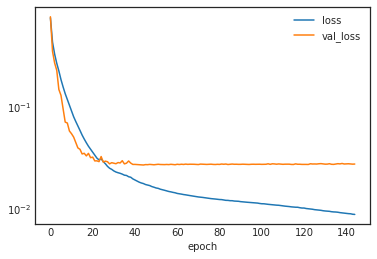

In [90]:
(pd.read_csv(CSV_LOG)
 .set_index('epoch')
 [['loss', 'val_loss']]
 .plot(logy=True))

In [79]:
pd.read_parquet(ACCURACY_FILE)[0:20].style.bar()

In [57]:
res = pd.read_parquet(RESULT_FILE)
cols = res.columns[2:12].tolist() + ['in_top_190']

(res.groupby('TO').sum()[cols]
 .sort_values('in_top_5', ascending=False)
 .rename(columns = {'in_top_190' : 'n genes'})
)

in_top_1  in_top_2  \
TO                                                                       
plant embryo development trait                            11        11   
plant height                                               1         2   
disease resistance                                         2         2   
root shape                                                 2         2   
leaf morphology trait                                      2         2   
fungal disease resistance                                  1         1   
fruit yield trait                                          2         2   
far red light sensitivity                                  2         2   
oxidative stress                                           2         2   
viral disease resistance                                   1         2   
bacterial disease resistance                               1         1   
root hair density                                          1         1   
male sterility                                             1         1   
leaf gloss                                                 1         1   
abscisic acid content                                      1         1   
trichome morphology trait                                  1         1   
sterility or fertility trait                               0         1   
stem morphology trait                                      0         0   
leaf number                                                1         1   
leaf senescence trait                                      1         1   
leaf shape                                                 1         1   
leaf trichome density                                      1         1   
light sensitivity                                          0         0   
shoot apical meristem development                          1         1   
relative growth rate                                       1         1   
meiotic cell cycle trait                                   1         1   
metabolite content trait                                   1         1   
non photochemical quenching                                1         1   
heat tolerance                                             1         1   
phototropism response trait                                1         1   
...                                                      ...       ...   
pungency                                                   0         0   
auxin sensitivity                                          0         0   
root development trait                                     0         0   
spikelet number                                            0         0   
copper concentration                                       0         0   
biochemical trait                                          0         0   
salt tolerance                                             0         0   
grain width                                                0         0   
plant cell morphology trait                                0         0   
copper content trait                                       0         0   
hull color                                                 0         0   
hydrogen peroxide content                                  0         0   
grain number                                               0         0   
grain length                                               0         0   
leaf growth and development trait                          0         0   
leaf lamina morphology trait                               0         0   
leaf lamina width                                          0         0   
germination rate                                           0         0   
leaf size                                                  0         0   
flowering time trait                                       0         0   
floral organ development trait                             0         0   
male sterility type                                     

In [78]:
(
((res.groupby('TO').sum()[cols] + 0.001) / res.groupby('TO').count()[cols])
 
 .rename(columns = {'in_top_190' : 'n genes'}) 
 * 100
).round().sort_values('in_top_1', ascending=False)

in_top_1  in_top_2  \
TO                                                                       
fruit yield trait                                      100.0     100.0   
fruit ripening trait                                   100.0     100.0   
root shape                                             100.0     100.0   
far red light sensitivity                              100.0     100.0   
root hair density                                      100.0     100.0   
leaf number                                            100.0     100.0   
fruit growth and development trait                     100.0     100.0   
fruit morphology trait                                 100.0     100.0   
non photochemical quenching                            100.0     100.0   
leaf trichome density                                  100.0     100.0   
leaf morphology trait                                  100.0     100.0   
gibberellic acid sensitivity                           100.0     100.0   
plant color                                            100.0     100.0   
grain size                                             100.0     100.0   
abscisic acid content                                  100.0     100.0   
leaf gloss                                             100.0     100.0   
leaf shape                                             100.0     100.0   
endosperm quality                                      100.0     100.0   
biotic stress trait                                    100.0     100.0   
cell elongation trait                                  100.0     100.0   
trichome morphology trait                              100.0     100.0   
oxidative stress                                       100.0     100.0   
meiotic cell cycle trait                               100.0     100.0   
biological process trait                               100.0     100.0   
phyllotaxy                                             100.0     100.0   
phototropism response trait                            100.0     100.0   
heat tolerance                                         100.0     100.0   
chemical stress sensitivity                            100.0     100.0   
male sterility                                         100.0     100.0   
seed growth and development trait                      100.0     100.0   
...                                                      ...       ...   
abiotic stress trait                                     0.0       9.0   
multi-tissue plant structure morphology trait            0.0       0.0   
germination rate                                         0.0       0.0   
abscisic acid sensitivity                                0.0       0.0   
auxin sensitivity                                        0.0       0.0   
biochemical trait                                        0.0       0.0   
cell cycle trait                                         0.0       0.0   
chlorophyll content                                      0.0       0.0   
cold tolerance                                           0.0      33.0   
copper concentration                                     0.0       0.0   
copper content trait                                     0.0       0.0   
days to flowering trait                                  0.0       0.0   
endosperm storage protein content                        0.0       0.0   
floral organ development trait                           0.0       0.0   
flowering time trait                                     0.0       0.0   
grain length                                             0.0       0.0   
multi-tissue plant structure growth and develop...       0.0       0.0   
grain number                                             0.0       0.0   
grain width                                              0.0       0.0   
grain yield trait                                        0.0       0.0   
hull color                                               0.0       0.0   
hydrogen peroxide content                               

In [91]:
res

Entry                                            TO  in_top_1  \
0    A0A0N7KEX5                                  plant height         0   
1    A0A0N7KIZ1                          abiotic stress trait         0   
2    A0A0P0UZA9                          abiotic stress trait         0   
3    A0A0P0VFD3                      flower development trait         1   
4    A0A0P0VSP9                                  plant height         0   
5    A0A0P0WDD9                          abiotic stress trait         0   
6    A0A0P0WYN6                             drought tolerance         1   
7    A0A0P0XHX9                                  plant height         0   
8    A0A0P0XRJ8                             drought tolerance         0   
9    A0A0P0Y5F3                     fungal disease resistance         0   
10   A0A0U4C4X8                     fungal disease resistance         0   
11   A0A178UZG0                plant embryo development trait         1   
12   A0A178V474                plant embryo development trait         1   
13   A0A178W5M1                          relative growth rate         0   
14   A0A1B0SZS0                                  plant height         0   
15   A0A1P8B0U7                      meiotic cell cycle trait         1   
16   A0A1P8BCC6                plant embryo development trait         1   
17   A0A3Q7F295                     fungal disease resistance         0   
18   A0A3Q7F946                            disease resistance         1   
19   A0A3Q7GM10            fruit growth and development trait         1   
20   A0A3Q7H318                inflorescence morphology trait         0   
21   A0A3Q7HC54                             auxin sensitivity         0   
22   A0A3Q7IRG8                      viral disease resistance         1   
23   A0A3Q7J3I2                                male sterility         1   
24       A2ZFY7                      flower development trait         0   
25       A3AZ88                     fungal disease resistance         0   
26       B0F6T5                      viral disease resistance         0   
27       B0F832                    protist disease resistance         0   
28       B3IYE3                      metabolite content trait         0   
29       B9DFU2                                    phyllotaxy         1   
..          ...                                           ...       ...   
164      Q9LGE3                        root development trait         0   
165      Q9LJL3                         leaf morphology trait         1   
166      Q9LJR3                     far red light sensitivity         1   
167      Q9LKV7                             fruit yield trait         1   
168      Q9LNJ4                      flower development trait         0   
169      Q9LWU9                                  plant height         0   
170      Q9LX33  plant structure growth and development trait         0   
171      Q9M1S8                     abscisic acid sensitivity         0   
172      Q9M876                plant embryo development trait         1   
173      Q9S757                             root hair density         1   
174      Q9S7R4                                     leaf size         0   
175      Q9SAK4                             light sensitivity         0   
176      Q9SFD8             endosperm storage protein content         0   
177      Q9SJX7                   phototropism response trait         1   
178      Q9SRX9                           anthocyanin content         1   
179      Q9SS48             seed growth and development trait         1   
180      Q9STX9                          nutrient sensitivity         0   
181      Q9SZD4                        root development trait         0   
182      Q9SZJ5                          flowering time trait         0   
183      Q9XF67                              oxidative stress         1   
184      Q9XFM6                         cell elongation trait         1   
185      Q9XGF5                    